In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
data = pd.read_csv("./train.csv")
df_train = data.copy()
df_test = pd.read_csv("./test.csv")

In [ ]:
df_train

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52
...,...,...,...,...,...,...,...,...,...
150145,212638,09/07/13,9984,223245,235.8375,235.8375,0,0,38
150146,212639,09/07/13,9984,223153,235.8375,235.8375,0,0,30
150147,212642,09/07/13,9984,245338,357.6750,483.7875,1,1,31
150148,212643,09/07/13,9984,547934,141.7875,191.6625,0,1,12


# null values

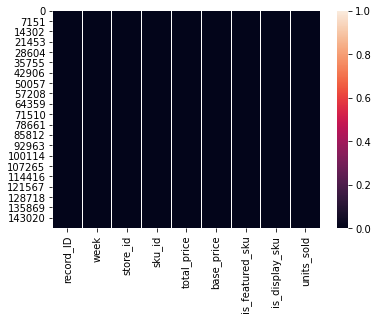

In [11]:
sns.heatmap(df_train.isnull())
df_train.isnull().sum()
df_train.dropna(inplace = True)

# correlation heatmap

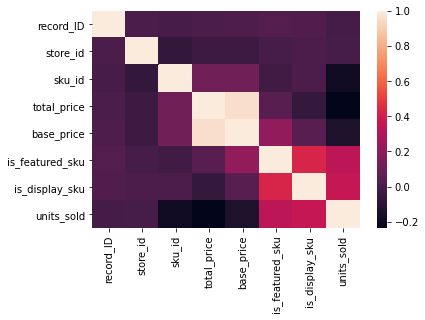

In [ ]:
sns.heatmap(df_train.corr())

# Data Preprocessing

In [12]:
def preprocess(df):
    df.drop(["record_ID", "week"], inplace = True, axis = 1)
    return df
    

In [13]:
X = df_train.drop(["units_sold"], axis = 1)
y = df_train.iloc[:, -1]
X = preprocess(X)

# plotting feature importance

In [14]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X, y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

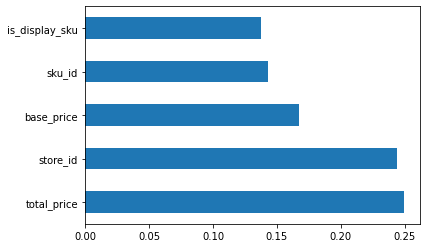

In [ ]:

feature_importance = pd.Series(model.feature_importances_, index = X.columns)
feature_importance
feature_importance.nlargest(5).plot(kind = "barh")

# train test split

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()

# hyperparametr tuning and model fitting 

In [ ]:
### hyper_paramters
n_estimators = [100*x for x in range(1, 13)]# no of trees in the decsion trees
max_features = ["auto", "sqrt"]
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf =  [1, 2, 5, 10]

In [ ]:
params = {
    "n_estimators" : n_estimators, 
    "max_features" : max_features, 
    "max_depth" : max_depth, 
    "min_samples_split" : min_samples_split, 
    "min_samples_leaf" : min_samples_leaf


}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf_random = RandomizedSearchCV(estimator = regressor, 
                               param_distributions = params, scoring = "neg_mean_squared_error", 
                              n_iter = 10, verbose = 2, random_state = 42, n_jobs = -1)


In [ ]:
rf_random.fit(X_train, y_train)


In [ ]:
rf_random.best_params_, rf_random.best_score_


In [ ]:
# model fitting

regressor = RandomForestRegressor(**{'n_estimators': 700,
  'min_samples_split': 15,
  'min_samples_leaf': 1,
  'max_features': 'auto',
  'max_depth': 20})
regressor.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=15, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
#saving the model
regressor_random_forest = regressor
import joblib
joblib.dump(regressor_random_forest, "regressor_random_forest")

['regressor_random_forest']

### Metric valuation

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)

In [ ]:
mse

920.9326941229832

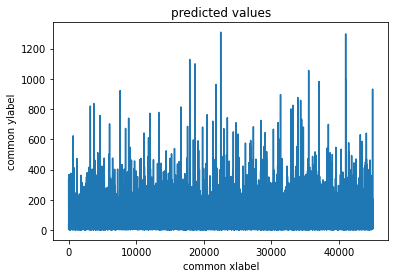

In [ ]:
ax = sns.lineplot([x for x in range(45045)], y_test, palette="Blues_d")
ax.set(xlabel='common xlabel', ylabel='common ylabel', title = "predicted values")
plt.show()

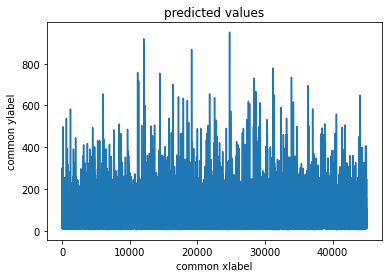

In [ ]:
ax = sns.lineplot([x for x in range(45045)], y_pred, palette="Blues_d")
ax.set(xlabel='common xlabel', ylabel='common ylabel', title = "predicted values")
plt.show()

In [ ]:
df_eval = pd.DataFrame({"x" : [x for x in range(45045)], "y_test":y_test, "y_pred": y_pred})
df_eval = pd.melt(df_eval, id_vars=['x'], value_vars=['y_test', 'y_pred'])

In [ ]:
ax = sns.barplot("x", y="value", data=df_eval,
                 palette="Blues_d")
plt.show

### Xgboost regressor

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [ ]:
regressor = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear', "reg:squarederror"],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.8],
              'n_estimators': [500, 1000]}
random_search = RandomizedSearchCV(regressor,parameters, cv = 2, n_jobs = -1, verbose = True)
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.7min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8],
                                        'learning_rate': [0.03

In [ ]:
random_search.best_params_, random_search.best_score_

({'colsample_bytree': 0.8,
  'learning_rate': 0.05,
  'max_depth': 7,
  'min_child_weight': 4,
  'n_estimators': 1000,
  'nthread': 4,
  'objective': 'reg:linear',
  'silent': 1,
  'subsample': 0.7},
 0.7910746144699151)

In [ ]:
regressor = XGBRegressor(**{'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'max_depth': 7,
  'min_child_weight': 4,
  'n_estimators': 1000,
  'nthread': 4,
  'objective': 'reg:linear',
  'silent': 1,
  'subsample': 0.7})
regressor.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=4, missing=None, n_estimators=1000,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.7, verbosity=1)

In [16]:
y_pred_2 = regressor.predict(X_test)
y_pred_2

array([ 35.846222,  20.215294, 351.77158 , ...,  21.483704,  67.32884 ,
       104.37678 ], dtype=float32)

In [18]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred_2)
mse

697.4095342989148

In [ ]:
regressor_xgboost = regressor
joblib.dump(regressor, "regressor_xgboost")

['regressor_xgboost']

In [7]:
import joblib
regressor = joblib.load("regressor_xgboost")

[10:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Test data prediction

In [19]:
df_test = preprocess(df_test)

In [29]:

y_pred_final = np.round(regressor.predict(df_test))

In [30]:
submission = pd.DataFrame({"SECTION" : y_pred_final})

In [34]:
submission.to_csv("submission.csv")